In [29]:
# Imports

import math, pickle, os, copy, sys, scipy.io, json, datetime

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

from numpy import random
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from utils_pv import *
from samples.data_sim import PVDataset

#### FL
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
from trainer import Trainer
from models import *
from metrics import mse

# Add the project directory to the path
PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(1, PROJECT_DIR)

# Set the random seed
random_seed = 46
random.seed(random_seed)
np.random.seed(random_seed)
random_state = np.random.RandomState(random_seed)

# Set the device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

months_name = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}

plt.rcParams.update({'font.size': 18})

### 0. Generate data for multiple households

In [2]:
# Generate data

NUM_CLIENTS=40

train_columns = ['H_sun', 'T2m', 'WS10m', 'hourofd_x', 'hourofd_y', 'dayofy_x', 'dayofy_y', 'station_irrad_direct_prev', 'station_irrad_diffuse_prev', 'lag 1']

hour_begin, hour_end = 8, 18

city_names = ['Lausanne']

# env_dict = {'city_names':city_names,
#             'num_clients': NUM_CLIENTS, 'num_modes': len(city_names),
#             'tilt_std': 5, 'az_std': 5, 'weather_dev':0.1,
#             'irrad_std':0.2, 'altitude_dev':0.1, 'shadow_peak_red':0.3,
#             'module_name': get_available_modules('sandia')[0:NUM_CLIENTS], #['Canadian_Solar_CS5P_220M___2009_'],
#             'inverter_name': get_available_inverters('cec')[0:NUM_CLIENTS], # ['ABB__MICRO_0_25_I_OUTD_US_208__208V_'],
#             'lags':[1], 'months':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'hours':np.arange(hour_begin, hour_end), 
#             'train_scenarios':{'1y':{'m_train':None, 'train_years':[2018], 'valid_years':2019}}}
# env_dict = PVDataset(env_dict).generate_clients_data()

# Load pickle
# env_dict = pickle.load(open('env_dict.pkl', 'rb'))
env_dict = pickle.load(open('env_dict_morevariation.pkl', 'rb'))

time_series = []

for client_ in range(NUM_CLIENTS):
    time_series_ = env_dict['train_scenarios']['1y']['time_series'][client_]

    # Remove nights
    time_series_ = time_series_[time_series_['hour_day'].isin(np.arange(hour_begin, hour_end))]

    # Add column day_of_month using column time
    time_series_['day'] = time_series_['time'].dt.day

    # Reorder columns
    time_series_ = time_series_[['time', 'year', 'month', 'day', 'hour_day', 'H_sun', 'T2m', 'WS10m', 'hourofd_x', 'hourofd_y', 'dayofy_x', 'dayofy_y', 'station_irrad_direct_prev', 'station_irrad_diffuse_prev', 'lag 1', 'target']]

    time_series.append(time_series_)

### 3. Scenario 3
> train with 1 month before prediction month

In [3]:
def FL_scenario3(lr_, weight_decay_, FL, test_years=[2014, 2015, 2016, 2017, 2018], selected_months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], verbose=False):
    results_list = []

    # Create a list of (year, month) tuples for training and testing
    year_month_pairs = []
    for year in test_years:
        for month in selected_months:
            if year == test_years[-1] and month == selected_months[-1]:  # no need to train the last month of the last year
                break
            year_month_pairs.append((year, month))

    initial_global_model = None
    client_models = [None] * NUM_CLIENTS

    for (year, month) in year_month_pairs:  # Loop over all months
        if verbose:
            print(f'lr: {lr_} - weight_decay: {weight_decay_} - year: {year} - month: {month}')

        # Set the random seed
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
        torch.manual_seed(random_seed)

        if FL:
            # Use the initial global model if provided, otherwise create a new one
            if initial_global_model is None:
                global_model = TwoLayerNN(input_dim=len(train_columns), output_dim=1, hidden_dim1=32, hidden_dim2=32).to(DEVICE)
                for name, param in global_model.named_parameters():
                    if 'weight' in name:
                        nn.init.xavier_normal_(param)
                    if 'bias' in name:
                        nn.init.zeros_(param)
            else:
                global_model = initial_global_model
        else:
            if month == 1 and year == test_years[0]:
                # Initialize client models for the first month of the first year
                global_model = TwoLayerNN(input_dim=len(train_columns), output_dim=1, hidden_dim1=32, hidden_dim2=32).to(DEVICE)
                for name, param in global_model.named_parameters():
                    if 'weight' in name:
                        nn.init.xavier_normal_(param)
                    if 'bias' in name:
                        nn.init.zeros_(param)
                client_models = [copy.deepcopy(global_model) for _ in range(NUM_CLIENTS)]
            else:
                # Use the latest model from the previous round
                client_models = [copy.deepcopy(client_models[i]) for i in range(NUM_CLIENTS)]

        if FL:
            # Define the client models
            client_models = [copy.deepcopy(global_model) for _ in range(NUM_CLIENTS)]

        # Store training values
        train_losses = {'client_{}'.format(i): {month: [] for month in selected_months} for i in range(NUM_CLIENTS)}
        client_data_stats = {'client_{}'.format(i): {month: {'x_mean': [], 'x_std': [], 'y_mean': [], 'y_std': []}
                                                     for month in selected_months} for i in range(NUM_CLIENTS)}
        client_batched_data = {'client_{}'.format(i): {month: {'x_train': [], 'y_train': []} for month in selected_months} for i in range(NUM_CLIENTS)}

        num_epochs = 150

        # Training loop
        for epoch in tqdm(range(num_epochs), desc="Epochs", disable=not verbose):
            for client_num in range(NUM_CLIENTS):
                # Each client receives its latest model
                client_model = client_models[client_num]
                client_model.train()

                # Define optimizer and trainer for the client's model
                optimizer = optim.Adam([param for param in client_model.parameters() if param.requires_grad],
                                       lr=lr_,
                                       weight_decay=weight_decay_)

                trainer = Trainer(
                    model=client_model,
                    criterion=nn.MSELoss(reduction='none').to(DEVICE),
                    metric=mse,
                    device=DEVICE,
                    optimizer=optimizer,
                    cast_label=False,
                )

                # Get the client's time series data
                time_series_client = time_series[client_num]

                if month == 12:
                    next_month = 1
                    next_year = year + 1
                else:
                    next_month = month + 1
                    next_year = year

                x_train = time_series_client[(time_series_client.year == year) &
                                             (time_series_client.month == month)][train_columns].values
                y_train = time_series_client[(time_series_client.year == year) &
                                             (time_series_client.month == month)]['target'].values

                x_mean, x_std = x_train.mean(axis=0), x_train.std(axis=0)
                y_mean, y_std = y_train.mean(), y_train.std()

                # Store the means and stds for the client and month if not already stored
                if len(client_data_stats['client_{}'.format(client_num)][month]['x_mean']) == 0:
                    client_data_stats['client_{}'.format(client_num)][month]['x_mean'] = x_mean
                    client_data_stats['client_{}'.format(client_num)][month]['x_std'] = x_std
                    client_data_stats['client_{}'.format(client_num)][month]['y_mean'] = y_mean
                    client_data_stats['client_{}'.format(client_num)][month]['y_std'] = y_std

                # Normalize the training data
                x_train = (x_train - x_mean) / x_std
                y_train = (y_train - y_mean) / y_std
                y_train = np.array(y_train).reshape(-1, 1)

                # Create the training dataset and dataloader
                train_dataset = TensorDataset(torch.tensor(x_train), torch.tensor(y_train))
                train_dataloader = DataLoader(train_dataset, batch_size=int(0.1 * len(x_train)), shuffle=True)

                # Only do one pass using batch size of the data
                # Get the first batch
                x_batch, y_batch = next(iter(train_dataloader))
                x_batch = x_batch.to(DEVICE).type(torch.float32)
                y_batch = y_batch.to(DEVICE).type(torch.float32)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = client_model(x_batch)
                loss = trainer.criterion(outputs, y_batch).mean()

                # Backward pass
                loss.backward()

                # Update the weights
                optimizer.step()

                # Store the training loss
                train_losses['client_{}'.format(client_num)][month].append(loss.item())

                # Store the batched data
                client_batched_data['client_{}'.format(client_num)][month]['x_train'].append(x_batch.cpu().numpy())
                client_batched_data['client_{}'.format(client_num)][month]['y_train'].append(y_batch.cpu().numpy())

            if FL:
                # Average the models and update the global model
                with torch.no_grad():
                    global_model_dict = global_model.state_dict()
                    for param in global_model_dict.keys():
                        param_sum = sum(client_models[i].state_dict()[param] for i in range(NUM_CLIENTS))
                        global_model_dict[param] = param_sum / NUM_CLIENTS
                    global_model.load_state_dict(global_model_dict)

                # Send the latest global model to each client
                client_models = [copy.deepcopy(global_model) for _ in range(NUM_CLIENTS)]

                # Set the model to evaluation mode
                global_model.eval()

        # Test for each client
        for client_num in range(NUM_CLIENTS):
            # Get the client's time series data
            time_series_client = time_series[client_num]
            x_test = time_series_client[(time_series_client.year == next_year) &
                                        (time_series_client.month == next_month)][train_columns].values
            y_test = time_series_client[(time_series_client.year == next_year) &
                                        (time_series_client.month == next_month)]['target'].values

            # Read the means and stds for this client and month
            x_mean, x_std = client_data_stats['client_{}'.format(client_num)][month]['x_mean'], \
                            client_data_stats['client_{}'.format(client_num)][month]['x_std']
            y_mean, y_std = client_data_stats['client_{}'.format(client_num)][month]['y_mean'], \
                            client_data_stats['client_{}'.format(client_num)][month]['y_std']

            # Normalize the test data
            x_test = (x_test - x_mean) / x_std
            y_test = (y_test - y_mean) / y_std
            y_test = np.array(y_test).reshape(-1, 1)

            # Get the predictions
            if FL:
                with torch.no_grad():
                    y_pred = global_model(torch.tensor(x_test).to(DEVICE).type(torch.float32))
            else:
                client_model = client_models[client_num]
                client_model.eval()
                with torch.no_grad():
                    y_pred = client_model(torch.tensor(x_test).to(DEVICE).type(torch.float32))

            # Compute the test loss
            test_loss = trainer.criterion(y_pred, torch.tensor(y_test).to(DEVICE).type(torch.float32)).mean()

            # Store the results
            result = {
                'lr': lr_,
                'weight_decay': weight_decay_,
                'train_month': month,
                'test_month': next_month,
                'train_year': year,
                'test_year': next_year,
                'client_num': client_num,
                'train_data': {'x_train': np.array(client_batched_data['client_{}'.format(client_num)][month]['x_train']),
                               'y_train': np.array(client_batched_data['client_{}'.format(client_num)][month]['y_train'])},
                'x_test': x_test * x_std + x_mean,
                'x_test_norm': x_test,
                'y_test': y_test * y_std + y_mean,
                'y_test_norm': y_test,
                'y_pred': y_pred.cpu().numpy() * y_std + y_mean,
                'y_pred_norm': y_pred.cpu().numpy(),
                'test_loss': test_loss.item(),
                'training_loss_history': train_losses['client_{}'.format(client_num)][month]
            }

            results_list.append(result)

        # Update the initial global model with the latest global model
        if FL:
            initial_global_model = global_model

        # Compute the latest training loss value of all client 
        train_loss = np.mean([np.mean(train_losses['client_{}'.format(i)][month]) for i in range(NUM_CLIENTS)])

        # Compute the avg test loss for this round
        avg_test_loss = np.mean([result['test_loss'] for result in results_list[-NUM_CLIENTS:]])

        if verbose:
            print(f'Average training loss: {train_loss:.4f} - Average test loss: {avg_test_loss:.4f}')
            print('--' * 20)

    # Return the final global model along with the results
    return results_list

In [4]:
# Define the values for lr, weight_decay, and test_years
# lr_values = [0.0001, 0.001, 0.05, 0.01]
# weight_decay_values = [5e-6, 5e-4, 5e-2, 1e-1, 0.25]

lr_values = [0.001]
weight_decay_values = [0.05]

results_dict = {}

# Define the total number of iterations
total_iterations = len(lr_values) * len(weight_decay_values)

with tqdm(total=total_iterations, desc="Progress") as pbar:
    for lr in lr_values:
        for weight_decay in weight_decay_values:
            # Initialize the initial global model to None
            key = (lr, weight_decay)
            results_list = FL_scenario3(lr, weight_decay, FL=False, verbose=False)
            results_dict[key] = pd.DataFrame(results_list)
            pbar.update(1)  # Update the progress bar

# Concatenate DataFrames for different configurations into a single DataFrame
final_df = pd.concat(results_dict.values(), ignore_index=True)

# Export to pickle
# final_df.to_pickle('FL_results/Scenario3/1client_batchsize10percent_150epochs.pkl')

final_df.sample(3)

Progress: 100%|██████████| 1/1 [08:01<00:00, 481.08s/it]


lr  weight_decay  train_month  test_month  train_year  test_year  \
2299  0.001          0.05           10          11        2018       2018   
369   0.001          0.05           10          11        2014       2014   
530   0.001          0.05            2           3        2015       2015   

      client_num                                         train_data  \
2299          19  {'x_train': [[[ 0.74122685  1.0841956   0.0377...   
369            9  {'x_train': [[[ 0.5831271  -1.3909366   0.2534...   
530           10  {'x_train': [[[-1.8817637   0.20667458 -0.8789...   

                                                 x_test  \
2299  [[16.16, 11.292884709614771, 0.534541080492904...   
369   [[16.16, 16.68306786098008, 0.0013047708272644...   
530   [[17.79, 7.122316086377905, 2.3406230712125526...   

                                            x_test_norm  \
2299  [[-0.500024363346726, -0.5518454306176541, -0....   
369   [[-0.500024363346726, 0.0591936632196198, -1.2...   
530   [[-0.14636222589871895, 0.7349154642470949, 0....   

                                                 y_test  \
2299  [[4.413990516046353], [7.935715304894694], [10...   
369   [[30.044337075148725], [49.23203163641044], [5...   
530   [[5.8330582200553], [3.5339134403930714], [12....   

                                            y_test_norm  \
2299  [[0.06311477290174687], [1.0432856911188149], ...   
369   [[0.4858434428886803], [1.5627528498264087], [...   
530   [[-0.6325511398309742], [-0.7390446275588642],...   

                                                 y_pred  \
2299  [[2.9736695], [5.7378035], [7.27443], [7.25387...   
369   [[25.859692], [37.809303], [43.36193], [38.847...   
530   [[4.22931], [16.637653], [18.390575], [20.7275...   

                                            y_pred_norm  test_loss  \
2299  [[-0.33775717], [0.43156], [0.8592359], [0.853...   0.114286   
369   [[0.25098026], [0.9216522], [1.2332933], [0.97...   0.235982   
530   [[-0.7068347], [-0.13209584], [-0.05090279], [...   0.290937   

                                  training_loss_history  
2299  [0.10279069095849991, 0.06435468792915344, 0.1...  
369   [0.25354090332984924, 0.16424529254436493, 0.1...  
530   [0.13113562762737274, 0.16577832400798798, 0.1...

#### Individual Training for 40 clients

In [5]:
# Compute best results from Scenario 3 with 1 client

df3_1client = pickle.load(open('FL_results/Scenario3/1client_batchsize10percent_150epochs.pkl', 'rb'))
# df3_1client = final_df

# compute nbr of gs values
nbr_gs_values = len(df3_1client['lr'].unique()) * len(df3_1client['weight_decay'].unique())
print(f'Scenario 3 tested with {nbr_gs_values} different hyperparameters combinations and {len(df3_1client.client_num.unique())} client(s)')

best_params = df3_1client.groupby(['lr', 'weight_decay'])['test_loss'].mean().idxmin()

print(f'Best parameters: lr={best_params[0]}, weight_decay={best_params[1]}')

display(df3_1client[(df3_1client['lr']==best_params[0]) & (df3_1client['weight_decay']==best_params[1])].groupby('test_year')['test_loss'].mean())

print('Overall loss over 5 years: %.3f ± %.3f' % (df3_1client[(df3_1client['lr']==best_params[0]) & (df3_1client['weight_decay']==best_params[1])].groupby('test_year')['test_loss'].mean().values.mean(), df3_1client[(df3_1client['lr']==best_params[0]) & (df3_1client['weight_decay']==best_params[1])].groupby('test_year')['test_loss'].mean().values.std()))

Scenario 3 tested with 1 different hyperparameters combinations and 40 client(s)
Best parameters: lr=0.001, weight_decay=0.05


test_year
2014    0.307323
2015    0.288005
2016    0.324982
2017    0.284338
2018    0.266754
Name: test_loss, dtype: float64

Overall loss over 5 years: 0.294 ± 0.020


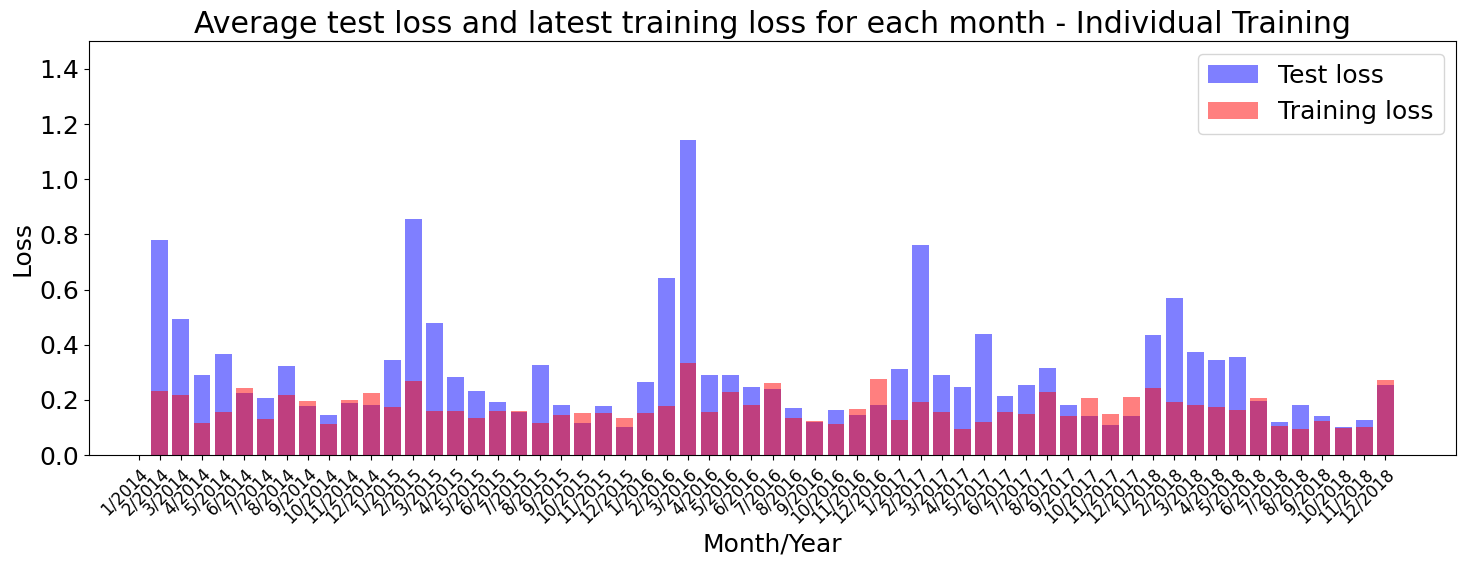

In [10]:
best_params = df3_1client.groupby(['lr', 'weight_decay'])['test_loss'].mean().idxmin()

lr = best_params[0]
weight_decay = best_params[1]

# for each month, year print the avg training loss of the latest epoch and the avg test loss
df3_best_1client = df3_1client[(df3_1client['lr']==lr) & (df3_1client['weight_decay']==weight_decay)]


# Plot as barplot the avg test loss and latest training loss for each month
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

for year in np.sort(df3_best_1client['test_year'].unique()):
    for month in np.sort(df3_best_1client['test_month'].unique()):
        subset = df3_best_1client[(df3_best_1client['test_year'] == year) & (df3_best_1client['test_month'] == month)]
        avg_test_loss = subset['test_loss'].mean()
        avg_train_loss = np.mean([np.mean(subset['training_loss_history'].values[i][-1]) for i in range(len(subset))])
        ax.bar(f'{month}/{year}', avg_test_loss, color='blue', alpha=0.5)
        ax.bar(f'{month}/{year}', avg_train_loss, color='red', alpha=0.5)
        
ax.set_title('Average test loss and latest training loss for each month - Individual Training')
ax.set_ylabel('Loss')
ax.set_xlabel('Month/Year')
ax.legend(['Test loss', 'Training loss'])
# offset to the left 
plt.xticks(rotation=45, ha='right',rotation_mode='anchor', fontsize=12)
plt.ylim(0, 1.5)
plt.tight_layout()
plt.show()

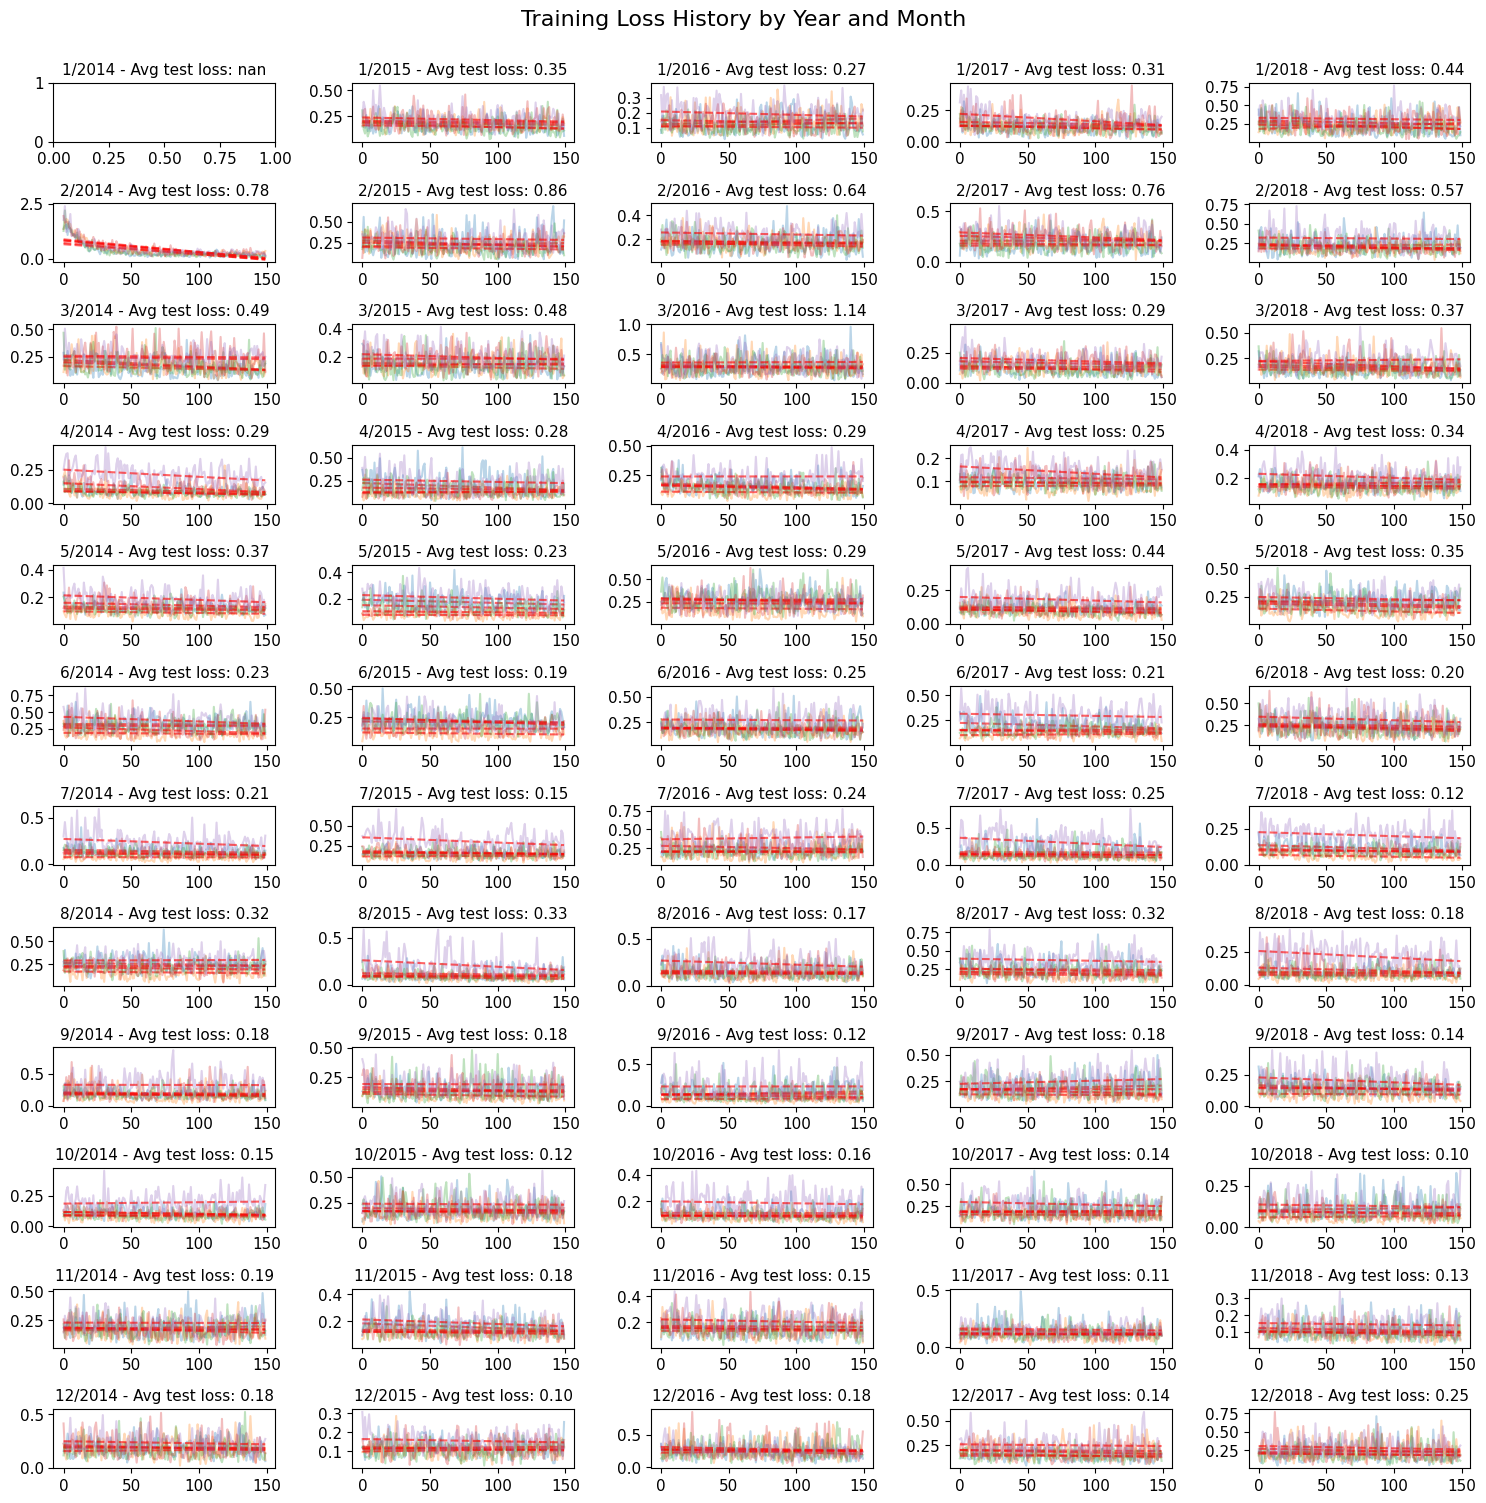

In [16]:
# Training loss history by year and month for 1 client

plt.rcParams.update({'font.size': 11})

years = df3_best_1client['test_year'].unique()
years = np.sort(years)
months = df3_best_1client['test_month'].unique()
months = np.sort(months)
clients = df3_best_1client['client_num'].unique()

# Determine the number of rows and columns for the subplots grid
n_rows = len(months)
n_cols = len(years)

# Create a figure and axes array of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15), constrained_layout=True)

for j, year in enumerate(years):
    for i, month in enumerate(months):
        ax = axes[i, j] if n_rows > 1 and n_cols > 1 else (axes[j] if n_cols > 1 else axes[i])
        subset = df3_best_1client[(df3_best_1client['test_year'] == year) & (df3_best_1client['test_month'] == month)]
        avg_test_loss = subset['test_loss'].mean()
        
        ax.set_title(f'{month}/{year} - Avg test loss: {avg_test_loss:.2f}', fontsize=11)
        for client_num in clients[:5]:
            client_data = subset[subset['client_num'] == client_num]
            if not client_data.empty:
                training_loss_history = client_data['training_loss_history'].values[0]
                epochs = np.arange(len(training_loss_history))
                ax.plot(training_loss_history, label=f'Client {client_num}', alpha=0.3)
                
                # Add linear regression line
                if len(epochs) > 1:  # Ensure there are enough data points to fit a line
                    coeffs = np.polyfit(epochs, training_loss_history, 1)
                    linear_fit = np.poly1d(coeffs)
                    ax.plot(epochs, linear_fit(epochs), linestyle='--', color='red', alpha=0.6)

# Add a main title to the figure
fig.suptitle('Training Loss History by Year and Month', fontsize=16, y=1)

# Add legend outside the subplots
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1))
plt.tight_layout()
plt.show()

#### FL for 40 clients

In [19]:
# Compute best results from Scenario 3 with 40 clients

df3_40clients = pickle.load(open('FL_results/Scenario3/40clients_batchsize10percent_150epochs.pkl', 'rb'))

# compute nbr of gs values
nbr_gs_values = len(df3_40clients['lr'].unique()) * len(df3_40clients['weight_decay'].unique())
print(f'Scenario 3 tested with {nbr_gs_values} different hyperparameters combinations and {len(df3_40clients.client_num.unique())} client(s)')

best_params = df3_40clients.groupby(['lr', 'weight_decay'])['test_loss'].mean().idxmin()

print(f'Best parameters: lr={best_params[0]}, weight_decay={best_params[1]}')

display(df3_40clients[(df3_40clients['lr']==best_params[0]) & (df3_40clients['weight_decay']==best_params[1])].groupby('test_year')['test_loss'].mean())

print('Overall loss over 5 years: %.3f ± %.3f' % (df3_40clients[(df3_40clients['lr']==best_params[0]) & (df3_40clients['weight_decay']==best_params[1])].groupby('test_year')['test_loss'].mean().values.mean(), df3_40clients[(df3_40clients['lr']==best_params[0]) & (df3_40clients['weight_decay']==best_params[1])].groupby('test_year')['test_loss'].mean().values.std()))

Scenario 3 tested with 20 different hyperparameters combinations and 40 client(s)
Best parameters: lr=0.001, weight_decay=0.05


test_year
2014    0.418028
2015    0.403795
2016    0.450378
2017    0.412858
2018    0.401431
Name: test_loss, dtype: float64

Overall loss over 5 years: 0.417 ± 0.018


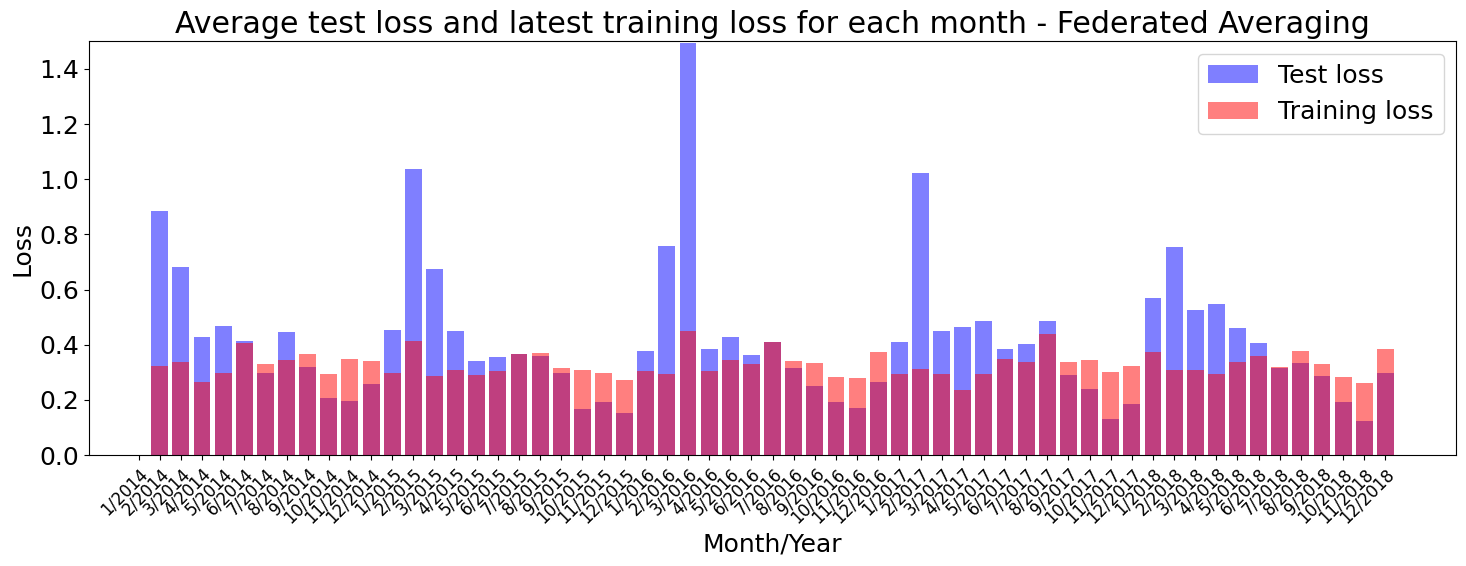

In [24]:
# for each month, year print the avg training loss of the latest epoch and the avg test loss

best_params = df3_40clients.groupby(['lr', 'weight_decay'])['test_loss'].mean().idxmin()

lr = best_params[0]
weight_decay = best_params[1]

df3_best_40clients = df3_40clients[(df3_40clients['lr']==lr) & (df3_40clients['weight_decay']==weight_decay)]

# Plot as barplot the avg test loss and latest training loss for each month
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

for year in np.sort(df3_best_40clients['test_year'].unique()):
    for month in np.sort(df3_best_40clients['test_month'].unique()):
        subset = df3_best_40clients[(df3_best_40clients['test_year'] == year) & (df3_best_40clients['test_month'] == month)]
        avg_test_loss = subset['test_loss'].mean()
        avg_train_loss = np.mean([np.mean(subset['training_loss_history'].values[i][-1]) for i in range(len(subset))])
        ax.bar(f'{month}/{year}', avg_test_loss, color='blue', alpha=0.5)
        ax.bar(f'{month}/{year}', avg_train_loss, color='red', alpha=0.5)
        
ax.set_title('Average test loss and latest training loss for each month - Federated Averaging')
ax.set_ylabel('Loss')
ax.set_xlabel('Month/Year')
ax.legend(['Test loss', 'Training loss'])
plt.xticks(rotation=45, ha='right',rotation_mode='anchor', fontsize=12)
plt.ylim(0, 1.5)
plt.tight_layout()
plt.show()

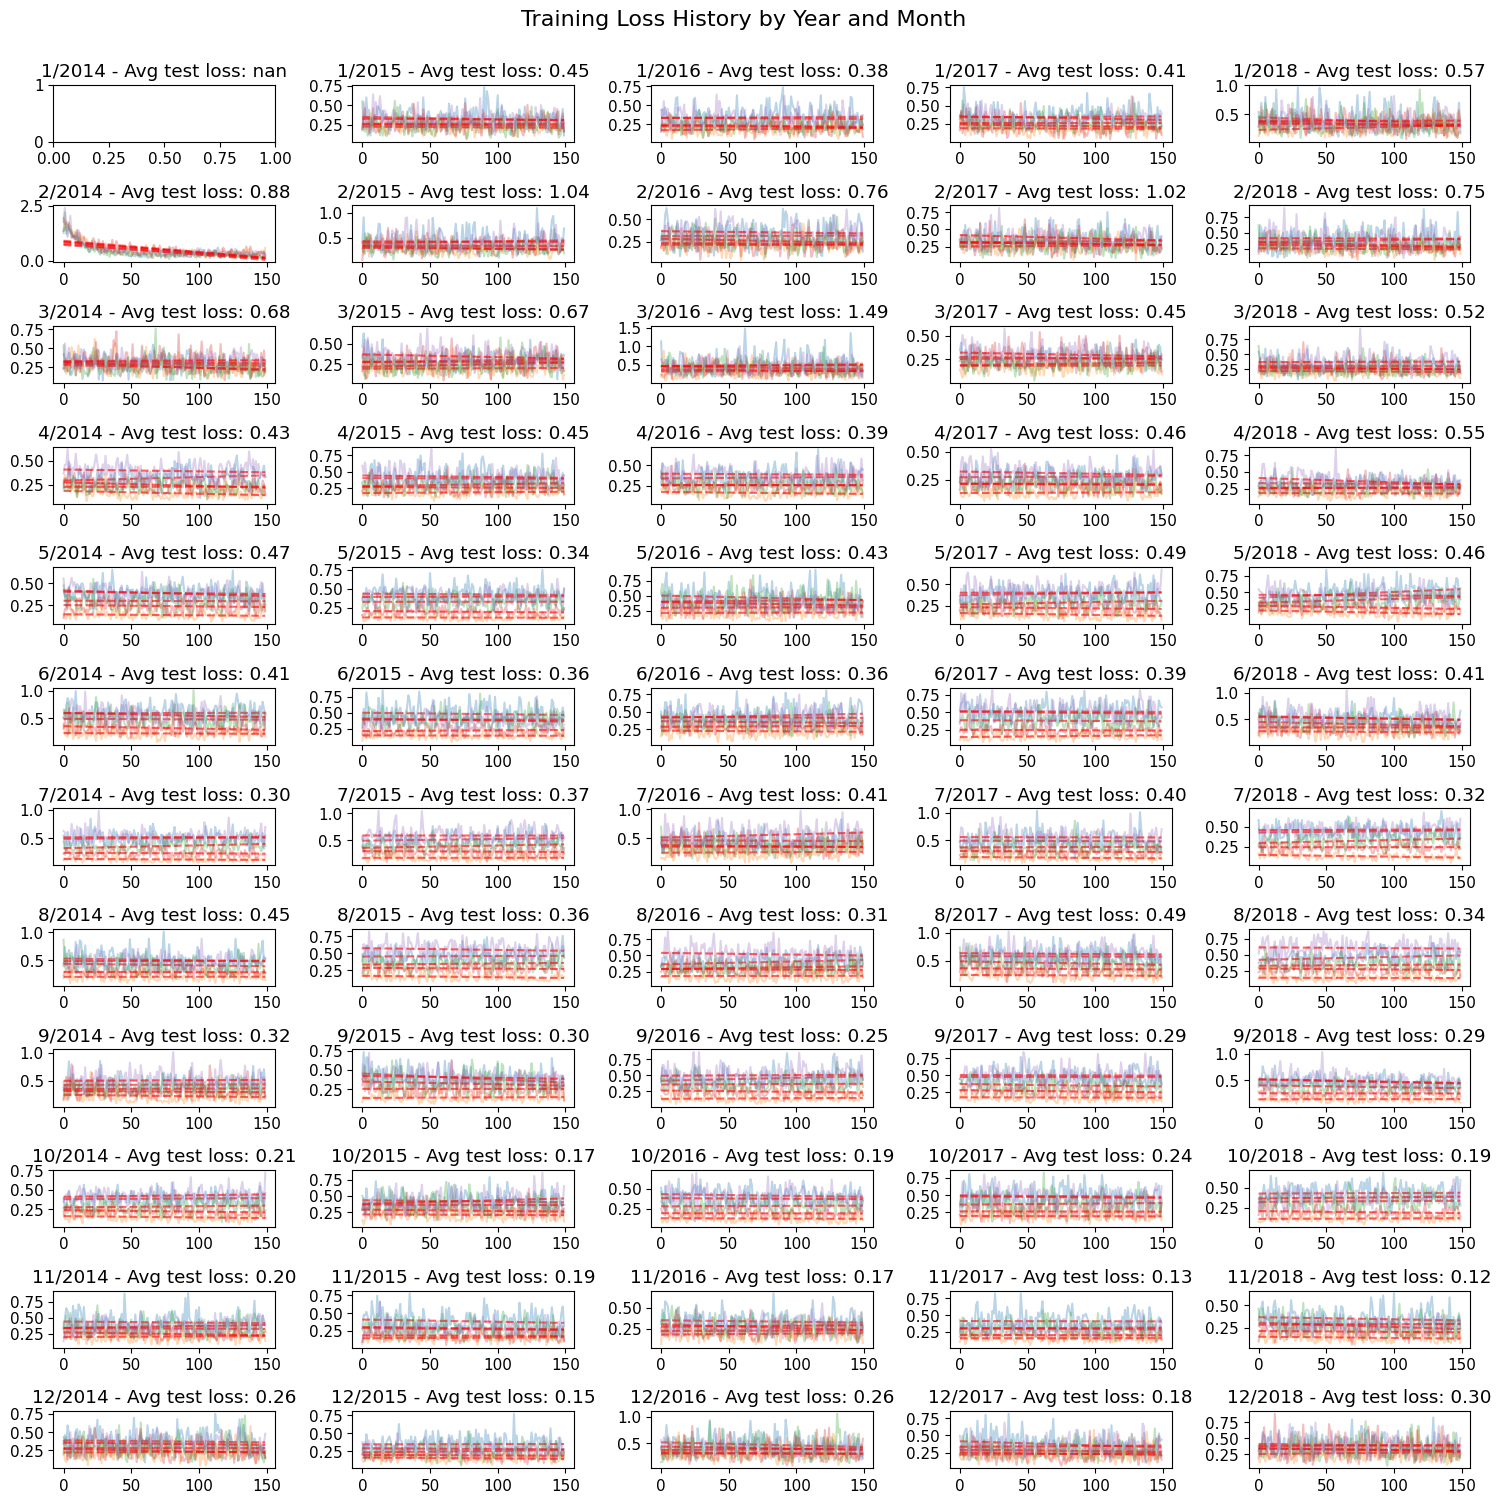

In [27]:
# Training loss history by year and month for 40 clients

plt.rcParams.update({'font.size': 11})

years = df3_best_40clients['test_year'].unique()
years = np.sort(years)
months = df3_best_40clients['test_month'].unique()
months = np.sort(months)
clients = df3_best_40clients['client_num'].unique()

# Determine the number of rows and columns for the subplots grid
n_rows = len(months)
n_cols = len(years)

# Create a figure and axes array of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15), constrained_layout=True)

for j, year in enumerate(years):
    for i, month in enumerate(months):
        ax = axes[i, j] if n_rows > 1 and n_cols > 1 else (axes[j] if n_cols > 1 else axes[i])
        subset = df3_best_40clients[(df3_best_40clients['test_year'] == year) & (df3_best_40clients['test_month'] == month)]
        avg_test_loss = subset['test_loss'].mean()
        
        ax.set_title(f'{month}/{year} - Avg test loss: {avg_test_loss:.2f}')
        for client_num in clients[:5]:
            client_data = subset[subset['client_num'] == client_num]
            if not client_data.empty:
                training_loss_history = client_data['training_loss_history'].values[0]
                epochs = np.arange(len(training_loss_history))
                ax.plot(training_loss_history, label=f'Client {client_num}', alpha=0.3)
                
                # Add linear regression line
                if len(epochs) > 1:  # Ensure there are enough data points to fit a line
                    coeffs = np.polyfit(epochs, training_loss_history, 1)
                    linear_fit = np.poly1d(coeffs)
                    ax.plot(epochs, linear_fit(epochs), linestyle='--', color='red', alpha=0.6)

# Add a main title to the figure
fig.suptitle('Training Loss History by Year and Month', fontsize=16, y=1)

# Add legend outside the subplots
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1))
plt.tight_layout()
plt.show()

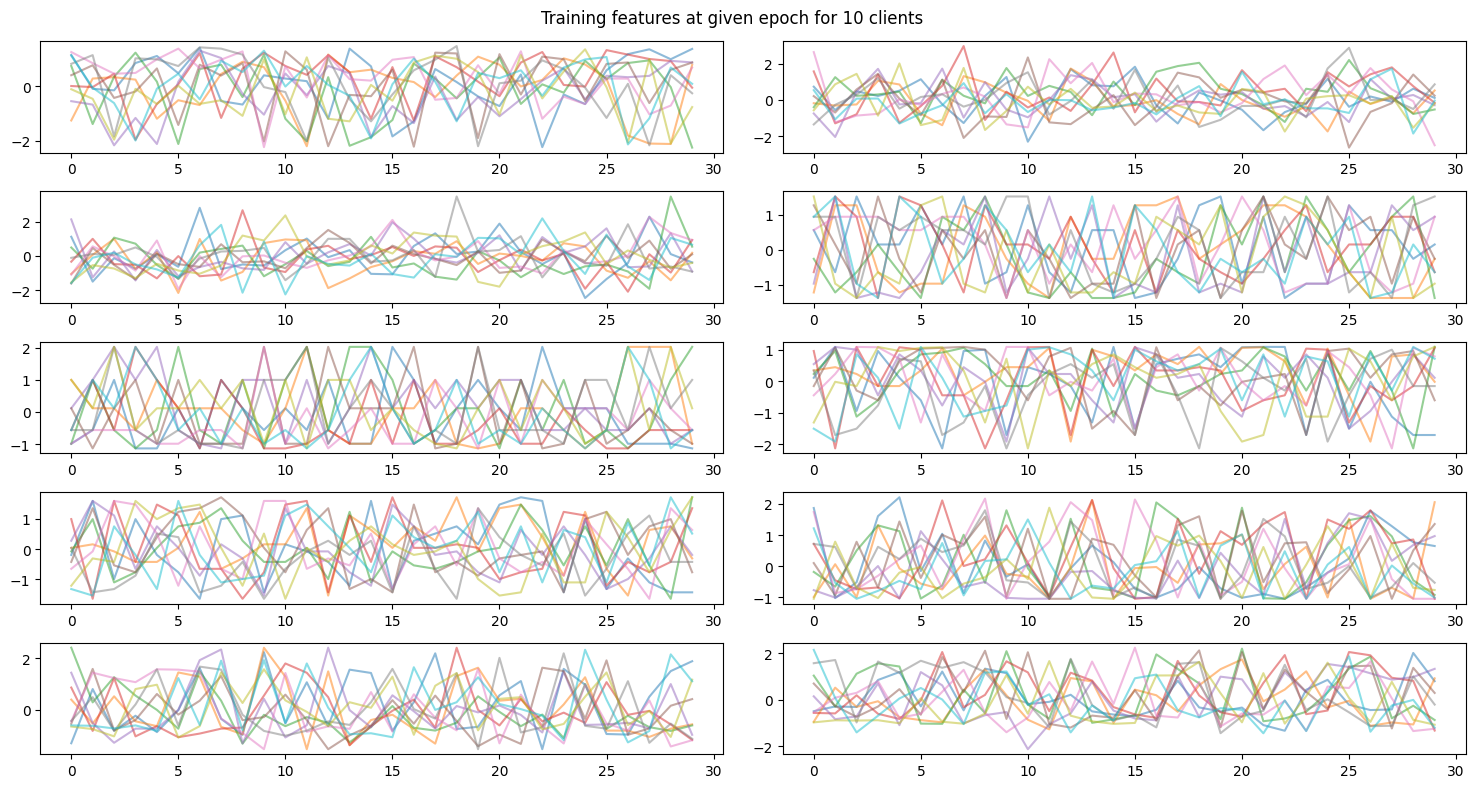

In [23]:
# Training features at given epoch for 10 clients
plt.figure(figsize=(15, 8))
plt.suptitle('Training features at given epoch for 10 clients')
for col in range(10): # 10 features
    plt.subplot(5, 2, col+1)
    for client in range(10): 
        plt.plot(df3_best_40clients[(df3_best_40clients['test_year']==2018) & (df3_best_40clients['test_month']==5) & (df3_best_40clients['client_num']==client)]['train_data'].values[0]['x_train'][10,:,col], label=f'Client {client}', alpha=0.5)
        # plt.legend()
plt.tight_layout()
plt.show()

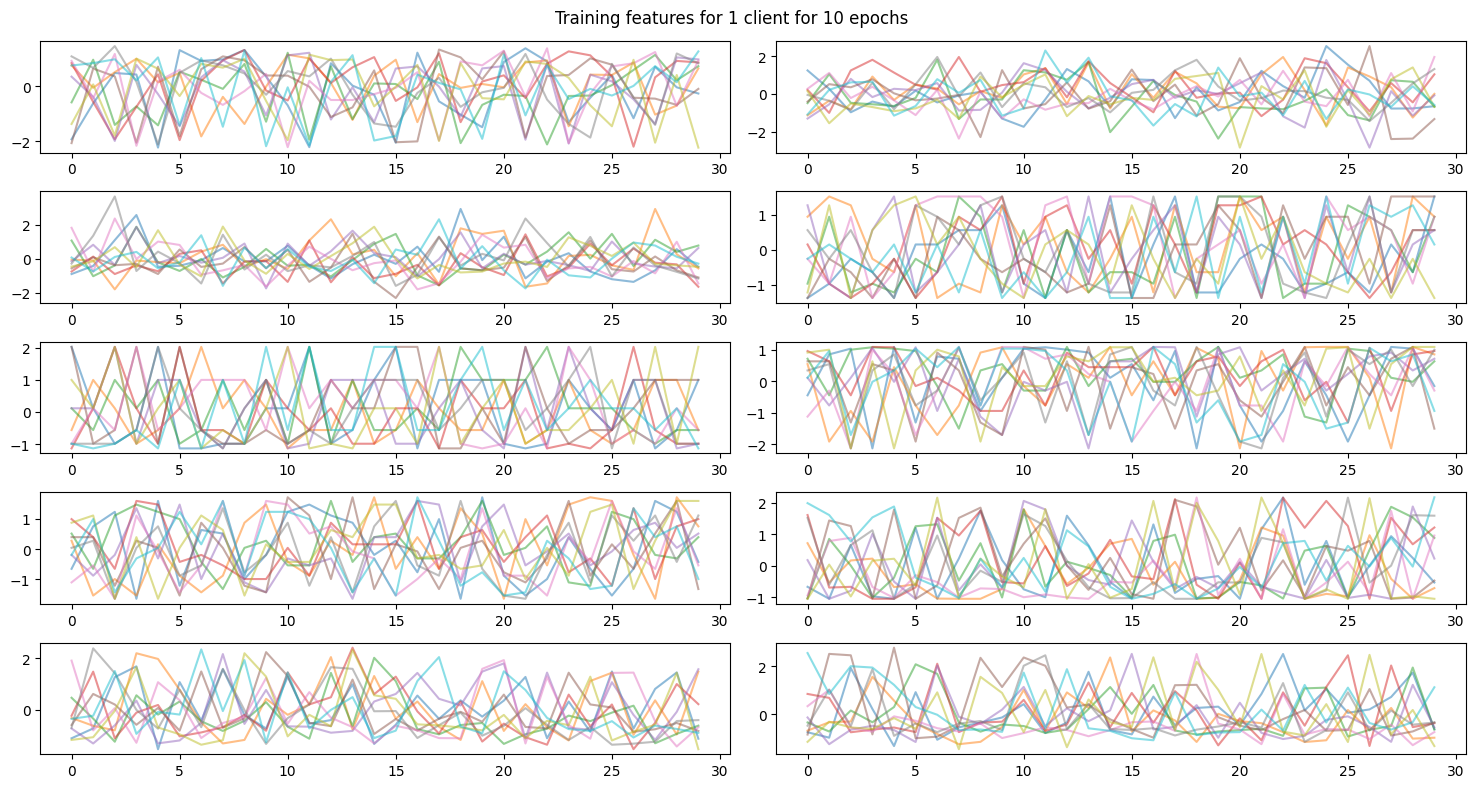

In [24]:
# Training features for 1 client for 10 epochs
plt.figure(figsize=(15, 8))
plt.suptitle('Training features for 1 client for 10 epochs')
for col in range(10): # 10 features
    plt.subplot(5, 2, col+1)
    for epoch in range(10): # Each epoch has the same training data, but we batch it differently
        plt.plot(df3_best_40clients[(df3_best_40clients['test_year']==2018) & (df3_best_40clients['test_month']==5) & (df3_best_40clients['client_num']==0)]['train_data'].values[0]['x_train'][epoch,:,col], label=f'Epoch {epoch}', alpha=0.5)
        # plt.legend()
plt.tight_layout()
plt.show()

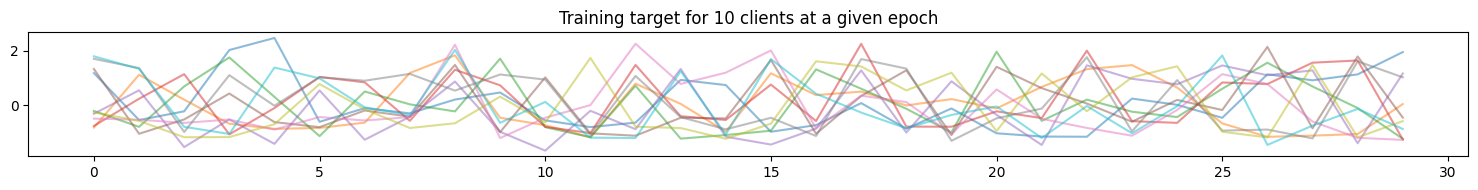

In [25]:
# Training target for 10 clients at a given epoch
plt.figure(figsize=(15, 2))
plt.title('Training target for 10 clients at a given epoch')
for client in range(10):
    plt.plot(df3_best_40clients[(df3_best_40clients['test_year']==2018) & (df3_best_40clients['test_month']==5) & (df3_best_40clients['client_num']==client)]['train_data'].values[0]['y_train'][10], label=f'Client {client}', alpha=0.5)
    # plt.legend()
plt.tight_layout()
plt.show()

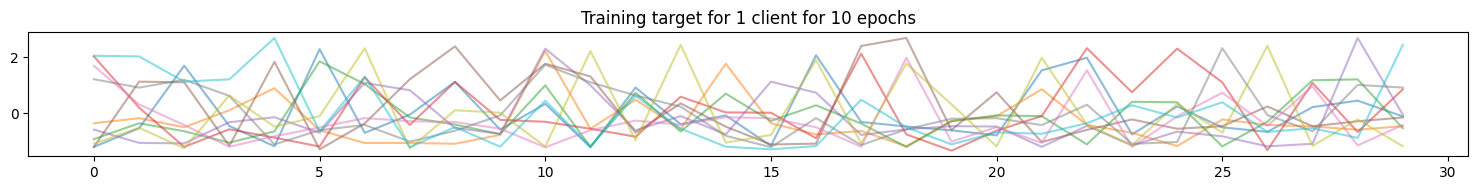

In [26]:
# Training target for 1 client for 10 epochs
plt.figure(figsize=(15, 2))
plt.title('Training target for 1 client for 10 epochs')
for epoch in range(10):
    plt.plot(df3_best_40clients[(df3_best_40clients['test_year']==2018) & (df3_best_40clients['test_month']==5) & (df3_best_40clients['client_num']==0)]['train_data'].values[0]['y_train'][epoch], label=f'Epoch {epoch}', alpha=0.5)
    # plt.legend()
plt.tight_layout()
plt.show()

> Federated Averaging does not improve the overall loss, but allows for a reduction of the ovefitting problem. If we wanted to improve the results, we should implement personnalization between the clients.

### 6. Scenario 6
> historical and fresh data 

In [3]:
def FL_scenario6(lr_, weight_decay_, memory_weight_, FL, test_years=[2014, 2015, 2016, 2017, 2018], selected_months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], N_HISTORICAL_SAMPLES=100, N_FRESH_DAYS=15, verbose=False):
    results_list = []

    # Create a list of (year, month) tuples for training and testing
    year_month_pairs = []
    for year in test_years:
        for month in selected_months:
            if year == test_years[-1] and month == selected_months[-1]:  # no need to train the last month of the last year
                break
            year_month_pairs.append((year, month))

    initial_global_model = None
    client_models = [None] * NUM_CLIENTS

    for (year, month) in year_month_pairs:  # Loop over all months
        if verbose:
            print(f'lr: {lr_} - weight_decay: {weight_decay_} - year: {year} - month: {month}')
        
        current_date = datetime.date(year, month, 1)

        # Set the random seed
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
        torch.manual_seed(random_seed)

        if FL:
            # Use the initial global model if provided, otherwise create a new one
            if initial_global_model is None:
                global_model = TwoLayerNN(input_dim=len(train_columns), output_dim=1, hidden_dim1=32, hidden_dim2=32).to(DEVICE)
                for name, param in global_model.named_parameters():
                    if 'weight' in name:
                        nn.init.xavier_normal_(param)
                    if 'bias' in name:
                        nn.init.zeros_(param)
            else:
                global_model = initial_global_model
        else:
            if month == 1 and year == test_years[0]:
                # Initialize client models for the first month of the first year
                global_model = TwoLayerNN(input_dim=len(train_columns), output_dim=1, hidden_dim1=32, hidden_dim2=32).to(DEVICE)
                for name, param in global_model.named_parameters():
                    if 'weight' in name:
                        nn.init.xavier_normal_(param)
                    if 'bias' in name:
                        nn.init.zeros_(param)
                client_models = [copy.deepcopy(global_model) for _ in range(NUM_CLIENTS)]
            else:
                # Use the latest model from the previous round
                client_models = [copy.deepcopy(client_models[i]) for i in range(NUM_CLIENTS)]

        if FL:
            # Define the client models
            client_models = [copy.deepcopy(global_model) for _ in range(NUM_CLIENTS)]

        # Store training values
        train_losses = {'client_{}'.format(i): {month: [] for month in selected_months} for i in range(NUM_CLIENTS)}
        client_data_stats = {'client_{}'.format(i): {month: {'x_mean': [], 'x_std': [], 'y_mean': [], 'y_std': []}
                                                     for month in selected_months} for i in range(NUM_CLIENTS)}
        client_batched_data = {'client_{}'.format(i): {month: {'x_memory': [], 'y_memory': [], 'x_stream': [], 'y_stream': []} for month in selected_months} for i in range(NUM_CLIENTS)}

        num_epochs = 50

        # Training loop
        for epoch in tqdm(range(num_epochs), desc="Epochs", disable=not verbose):
            for client_num in range(NUM_CLIENTS):
                # Each client receives its latest model
                client_model = client_models[client_num]
                client_model.train()

                # Define optimizer and trainer for the client's model
                optimizer = optim.Adam([param for param in client_model.parameters() if param.requires_grad],
                                       lr=lr_,
                                       weight_decay=weight_decay_)

                trainer = Trainer(
                    model=client_model,
                    criterion=nn.MSELoss(reduction='none').to(DEVICE),
                    metric=mse,
                    device=DEVICE,
                    optimizer=optimizer,
                    cast_label=False,
                )

                # Get the client's time series data
                time_series_client = time_series[client_num]

                if month == 12:
                    next_month = 1
                    next_year = year + 1
                else:
                    next_month = month + 1
                    next_year = year
                
                # Memory: random samples from the prediction window of previous years
                memory = []
                for _, row in time_series_client[(time_series_client['time'] > pd.to_datetime(current_date + pd.DateOffset(days=1))) & (time_series_client['time'] <= pd.to_datetime(current_date) + pd.DateOffset(days=30))].groupby(['month', 'day'])['time'].count().reset_index().iterrows():
                    memory.append(time_series_client[(time_series_client['month'] == row['month']) & (time_series_client['day'] == row['day']) & (time_series_client['year']<current_date.year)])
                memory = pd.concat(memory)
                memory = memory.sample(N_HISTORICAL_SAMPLES, random_state=random_seed+epoch)
                
                x_memory = memory[train_columns].values
                y_memory = memory['target'].values.reshape(-1, 1)
                
                x_mean, x_std = x_memory.mean(axis=0), x_memory.std(axis=0)
                y_mean, y_std = y_memory.mean(axis=0), y_memory.std(axis=0)
                
                x_memory = (x_memory - x_mean) / x_std
                y_memory = (y_memory - y_mean) / y_std

                memory_dataset = torch.utils.data.TensorDataset(torch.tensor(x_memory), torch.tensor(y_memory))
                memory_dataloader = DataLoader(memory_dataset, batch_size=int(0.05*len(x_memory)), shuffle=True)
                
                # Stream: Last N_FRESH_DAYS days
                start_date = pd.to_datetime(current_date - pd.DateOffset(days=N_FRESH_DAYS))
                end_date = pd.to_datetime(current_date)
                stream = time_series_client[(time_series_client['time'] > start_date) & (time_series_client['time'] < end_date)]

                x_stream = stream[train_columns].values
                y_stream = stream['target'].values.reshape(-1, 1)

                x_stream = (x_stream - x_mean) / x_std
                y_stream = (y_stream - y_mean) / y_std

                stream_dataset = torch.utils.data.TensorDataset(torch.tensor(x_stream), torch.tensor(y_stream))
                stream_dataloader = DataLoader(stream_dataset, batch_size=int(0.05*len(x_stream)), shuffle=True)

                # Store the means and stds for the client and month if not already stored
                if len(client_data_stats['client_{}'.format(client_num)][month]['x_mean']) == 0:
                    client_data_stats['client_{}'.format(client_num)][month]['x_mean'] = x_mean
                    client_data_stats['client_{}'.format(client_num)][month]['x_std'] = x_std
                    client_data_stats['client_{}'.format(client_num)][month]['y_mean'] = y_mean
                    client_data_stats['client_{}'.format(client_num)][month]['y_std'] = y_std

                if memory_weight_!=1:
                    x_batch_memory, y_batch_memory = next(iter(memory_dataloader))
                    x_batch_memory = x_batch_memory.to(DEVICE).type(torch.float32)
                    y_batch_memory = y_batch_memory.to(DEVICE).type(torch.float32)
                    
                    optimizer.zero_grad()
                    
                    outputs = client_model(x_batch_memory)
                    loss_memory = trainer.criterion(outputs, y_batch_memory).mean()
                else:
                    loss_memory = 0
                    
                if memory_weight_!=0:
                    x_batch_stream, y_batch_stream = next(iter(stream_dataloader))
                    x_batch_stream = x_batch_stream.to(DEVICE).type(torch.float32)
                    y_batch_stream = y_batch_stream.to(DEVICE).type(torch.float32)
                    
                    optimizer.zero_grad()
                    
                    outputs = client_model(x_batch_stream)
                    loss_stream = trainer.criterion(outputs, y_batch_stream).mean()
                else:
                    loss_stream = 0

                loss = memory_weight_ * loss_memory + (1-memory_weight_) * loss_stream

                # Backward pass
                loss.backward()

                # Update the weights
                optimizer.step()

                # Store the training loss
                train_losses['client_{}'.format(client_num)][month].append(loss.item())

                # Store the batched data
                client_batched_data['client_{}'.format(client_num)][month]['x_memory'].append(x_batch_memory.cpu().numpy())
                client_batched_data['client_{}'.format(client_num)][month]['y_memory'].append(y_batch_memory.cpu().numpy())
                client_batched_data['client_{}'.format(client_num)][month]['x_stream'].append(x_batch_stream.cpu().numpy())
                client_batched_data['client_{}'.format(client_num)][month]['y_stream'].append(y_batch_stream.cpu().numpy())

            if FL:
                # Average the models and update the global model
                with torch.no_grad():
                    global_model_dict = global_model.state_dict()
                    for param in global_model_dict.keys():
                        param_sum = sum(client_models[i].state_dict()[param] for i in range(NUM_CLIENTS))
                        global_model_dict[param] = param_sum / NUM_CLIENTS
                    global_model.load_state_dict(global_model_dict)

                # Send the latest global model to each client
                client_models = [copy.deepcopy(global_model) for _ in range(NUM_CLIENTS)]

                # Set the model to evaluation mode
                global_model.eval()

        # Test for each client
        for client_num in range(NUM_CLIENTS):
            # Get the client's time series data
            time_series_client = time_series[client_num]
            
            test = time_series_client[(time_series_client['time'] > pd.to_datetime(current_date + pd.DateOffset(days=1))) & (time_series_client['time'] <= pd.to_datetime(current_date) + pd.DateOffset(days=30))]
            
            x_test = test[train_columns].values
            y_test = test['target'].values.reshape(-1, 1)

            # Read the means and stds for this client and month
            x_mean, x_std = client_data_stats['client_{}'.format(client_num)][month]['x_mean'], \
                            client_data_stats['client_{}'.format(client_num)][month]['x_std']
            y_mean, y_std = client_data_stats['client_{}'.format(client_num)][month]['y_mean'], \
                            client_data_stats['client_{}'.format(client_num)][month]['y_std']

            # Normalize the test data
            x_test = (x_test - x_mean) / x_std
            y_test = (y_test - y_mean) / y_std
            y_test = np.array(y_test).reshape(-1, 1)

            # Get the predictions
            if FL:
                with torch.no_grad():
                    y_pred = global_model(torch.tensor(x_test).to(DEVICE).type(torch.float32))
            else:
                client_model = client_models[client_num]
                client_model.eval()
                with torch.no_grad():
                    y_pred = client_model(torch.tensor(x_test).to(DEVICE).type(torch.float32))

            # Compute the test loss
            test_loss = trainer.criterion(y_pred, torch.tensor(y_test).to(DEVICE).type(torch.float32)).mean()

            # Store the results
            result = {
                'lr': lr_,
                'weight_decay': weight_decay_,
                'memory_weight':memory_weight_,
                'train_month': month,
                'test_month': next_month,
                'train_year': year,
                'test_year': next_year,
                'client_num': client_num,
                'train_data': {'x_memory': np.array(client_batched_data['client_{}'.format(client_num)][month]['x_memory']),
                               'y_memory': np.array(client_batched_data['client_{}'.format(client_num)][month]['y_memory']),
                               'x_stream': np.array(client_batched_data['client_{}'.format(client_num)][month]['x_stream']),
                               'x_stream': np.array(client_batched_data['client_{}'.format(client_num)][month]['x_stream'])},
                'x_test': x_test * x_std + x_mean,
                'x_test_norm': x_test,
                'y_test': y_test * y_std + y_mean,
                'y_test_norm': y_test,
                'y_pred': y_pred.cpu().numpy() * y_std + y_mean,
                'y_pred_norm': y_pred.cpu().numpy(),
                'test_loss': test_loss.item(),
                'training_loss_history': train_losses['client_{}'.format(client_num)][month]
            }

            results_list.append(result)

        # Update the initial global model with the latest global model
        if FL:
            initial_global_model = global_model

        # Compute the latest training loss value of all client 
        train_loss = np.mean([np.mean(train_losses['client_{}'.format(i)][month]) for i in range(NUM_CLIENTS)])

        # Compute the avg test loss for this round
        avg_test_loss = np.mean([result['test_loss'] for result in results_list[-NUM_CLIENTS:]])

        if verbose:
            print(f'Average training loss: {train_loss:.4f} - Average test loss: {avg_test_loss:.4f}')
            print('--' * 20)

    # Return the final global model along with the results
    return results_list

In [5]:
# Define the values for lr, weight_decay, and test_years
# lr_values = [0.001, 0.05, 0.01]
# weight_decay_values = [5e-4, 5e-2, 1e-1, 0.25]
# memory_weight_values = [0.25, 0.5, 0.75]

lr_values = [0.001]
weight_decay_values = [5e-2]
memory_weight_values = [0.75]

results_dict = {}

# Define the total number of iterations
total_iterations = len(lr_values) * len(weight_decay_values) * len(memory_weight_values)

with tqdm(total=total_iterations, desc="Progress") as pbar:
    for lr in lr_values:
        for weight_decay in weight_decay_values:
            for memory_weight in memory_weight_values:
                # Initialize the initial global model to None
                key = (lr, weight_decay, memory_weight)
                results_list = FL_scenario6(lr, weight_decay, memory_weight, FL=True, verbose=False)
                results_dict[key] = pd.DataFrame(results_list)
                pbar.update(1)  # Update the progress bar

# Concatenate DataFrames for different configurations into a single DataFrame
final_df = pd.concat(results_dict.values(), ignore_index=True)

# Export to pickle
# final_df.to_pickle('FL_results/Scenario6/40clients_batchsize10percent_50epochs.pkl')

final_df.sample(3)

Progress: 100%|██████████| 1/1 [28:23<00:00, 1703.65s/it]


lr  weight_decay  memory_weight  train_month  test_month  train_year  \
627   0.001          0.05           0.75            4           5        2015   
357   0.001          0.05           0.75            9          10        2014   
1977  0.001          0.05           0.75            2           3        2018   

      test_year  client_num  \
627        2015          27   
357        2014          37   
1977       2018          17   

                                             train_data  \
627   {'x_memory': [[[ 0.7492508   0.35307953  0.540...   
357   {'x_memory': [[[ 0.4065671   1.0824679   1.015...   
1977  {'x_memory': [[[-0.13057184  0.3070673   0.145...   

                                                 x_test  \
627   [[29.15, 3.595259082553201, 3.222918057796826,...   
357   [[32.26, 14.919648272693303, 3.258234781237132...   
1977  [[10.140000000000002, 6.86875812900149, 0.0280...   

                                            x_test_norm  \
627   [[-0.7492357689706381, -1.2180829516958493, 1....   
357   [[-0.03662176944352383, -0.6838381494102239, 1...   
1977  [[-1.0872551609199828, 0.5256152247728362, -1....   

                                                 y_test  \
627   [[5.1300373652526705], [3.5656784751220343], [...   
357   [[15.98490109909166], [25.904888856602856], [3...   
1977  [[13.189464113997468], [20.154046657790847], [...   

                                            y_test_norm  \
627   [[-0.901160886088247], [-1.0870591766971], [-0...   
357   [[0.18718501447176805], [1.0628552676570002], ...   
1977  [[-0.4762437896249482], [-0.12131771756485865]...   

                                                 y_pred  \
627   [[8.908260087264175], [7.906561140539944], [6....   
357   [[15.038254187163572], [21.60280239277499], [2...   
1977  [[8.011857341522203], [22.246309618687803], [3...   

                                            y_pred_norm  test_loss  \
627   [[-0.45218134], [-0.57121676], [-0.73663354], ...   0.407891   
357   [[0.10362135], [0.6830958], [1.326177], [1.567...   0.169473   
1977  [[-0.74010277], [-0.014692709], [0.38431984], ...   0.351541   

                                  training_loss_history  
627   [0.2554476857185364, 0.2191995233297348, 0.166...  
357   [0.14122667908668518, 0.1221732497215271, 0.15...  
1977  [0.27701276540756226, 0.4036599099636078, 0.09...

In [30]:
# Compute best results from Scenario 6 with 1 client

df6_1client = pickle.load(open('FL_results/Scenario6/1client_batchsize10percent_50epochs.pkl', 'rb'))

# compute nbr of gs values
nbr_gs_values = len(df6_1client['lr'].unique()) * len(df6_1client['weight_decay'].unique()) * len(df6_1client['memory_weight'].unique())
print(f'Scenario 6 tested with {nbr_gs_values} different hyperparameters combinations and {len(df6_1client.client_num.unique())} client(s)')

best_params = df6_1client.groupby(['lr', 'weight_decay', 'memory_weight'])['test_loss'].mean().idxmin()

print(f'Best parameters: lr={best_params[0]}, weight_decay={best_params[1]}, memory_weight={best_params[2]}')

display(df6_1client[(df6_1client['lr']==best_params[0]) & (df6_1client['weight_decay']==best_params[1]) & (df6_1client['memory_weight']==best_params[2])].groupby('test_year')['test_loss'].mean())

print('Overall loss over 5 years: %.3f ± %.3f' % (df6_1client[(df6_1client['lr']==best_params[0]) & (df6_1client['weight_decay']==best_params[1]) & (df6_1client['memory_weight']==best_params[2])].groupby('test_year')['test_loss'].mean().values.mean(), df6_1client[(df6_1client['lr']==best_params[0]) & (df6_1client['weight_decay']==best_params[1]) & (df6_1client['memory_weight']==best_params[2])].groupby('test_year')['test_loss'].mean().values.std()))

Scenario 6 tested with 1 different hyperparameters combinations and 40 client(s)
Best parameters: lr=0.001, weight_decay=0.05, memory_weight=0.75


test_year
2014    0.271330
2015    0.227125
2016    0.215217
2017    0.230766
2018    0.233146
Name: test_loss, dtype: float64

Overall loss over 5 years: 0.236 ± 0.019


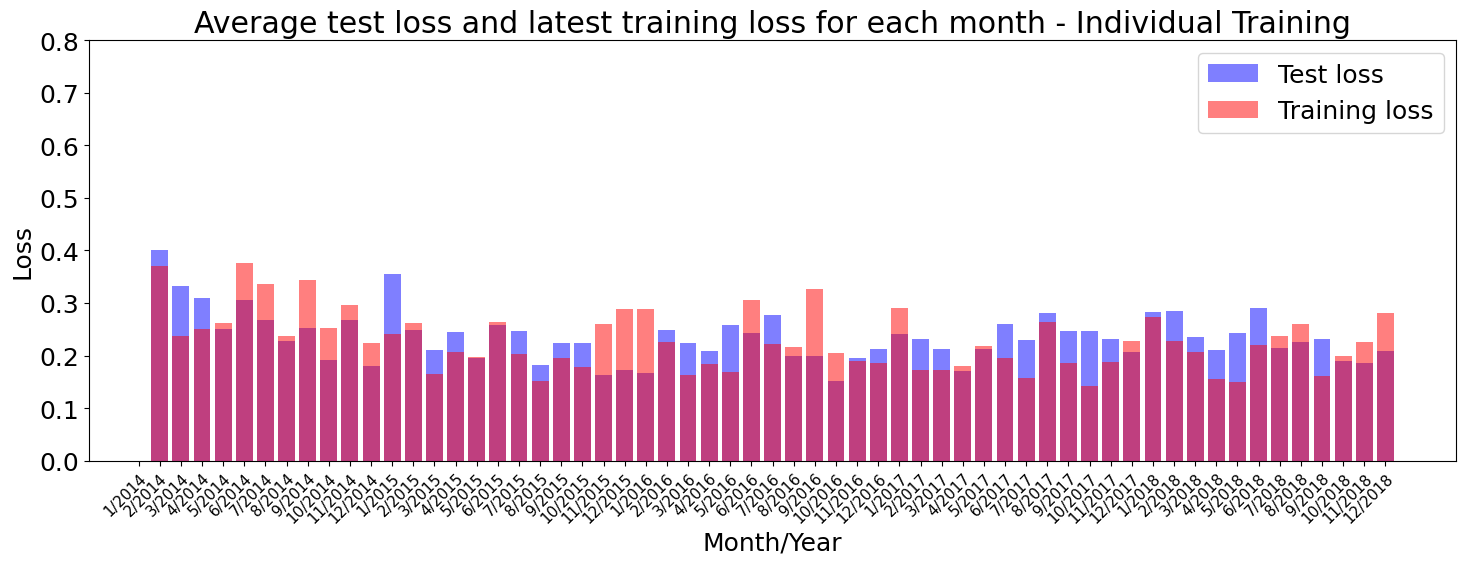

In [35]:
# for each month, year print the avg training loss of the latest epoch and the avg test loss - 1 client

best_params = df6_1client.groupby(['lr', 'weight_decay', 'memory_weight'])['test_loss'].mean().idxmin()

lr = best_params[0]
weight_decay = best_params[1]
memory_weight = best_params[2]

# for each month, year print the avg training loss of the latest epoch and the avg test loss
df6_best_1client = df6_1client[(df6_1client['lr']==lr) & (df6_1client['weight_decay']==weight_decay) & (df6_1client['memory_weight']==memory_weight)]

# Plot as barplot the avg test loss and latest training loss for each month
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

for year in np.sort(df6_best_1client['test_year'].unique()):
    for month in np.sort(df6_best_1client['test_month'].unique()):
        subset = df6_best_1client[(df6_best_1client['test_year'] == year) & (df6_best_1client['test_month'] == month)]
        avg_test_loss = subset['test_loss'].mean()
        avg_train_loss = np.mean([np.mean(subset['training_loss_history'].values[i][-1]) for i in range(len(subset))])
        ax.bar(f'{month}/{year}', avg_test_loss, color='blue', alpha=0.5)
        ax.bar(f'{month}/{year}', avg_train_loss, color='red', alpha=0.5)
        
ax.set_title('Average test loss and latest training loss for each month - Individual Training')
ax.set_ylabel('Loss')
ax.set_xlabel('Month/Year')
ax.legend(['Test loss', 'Training loss'])
# offset to the left 
plt.xticks(rotation=45, ha='right',rotation_mode='anchor', fontsize=11)
plt.ylim(0, 0.8)
plt.tight_layout()
plt.show()

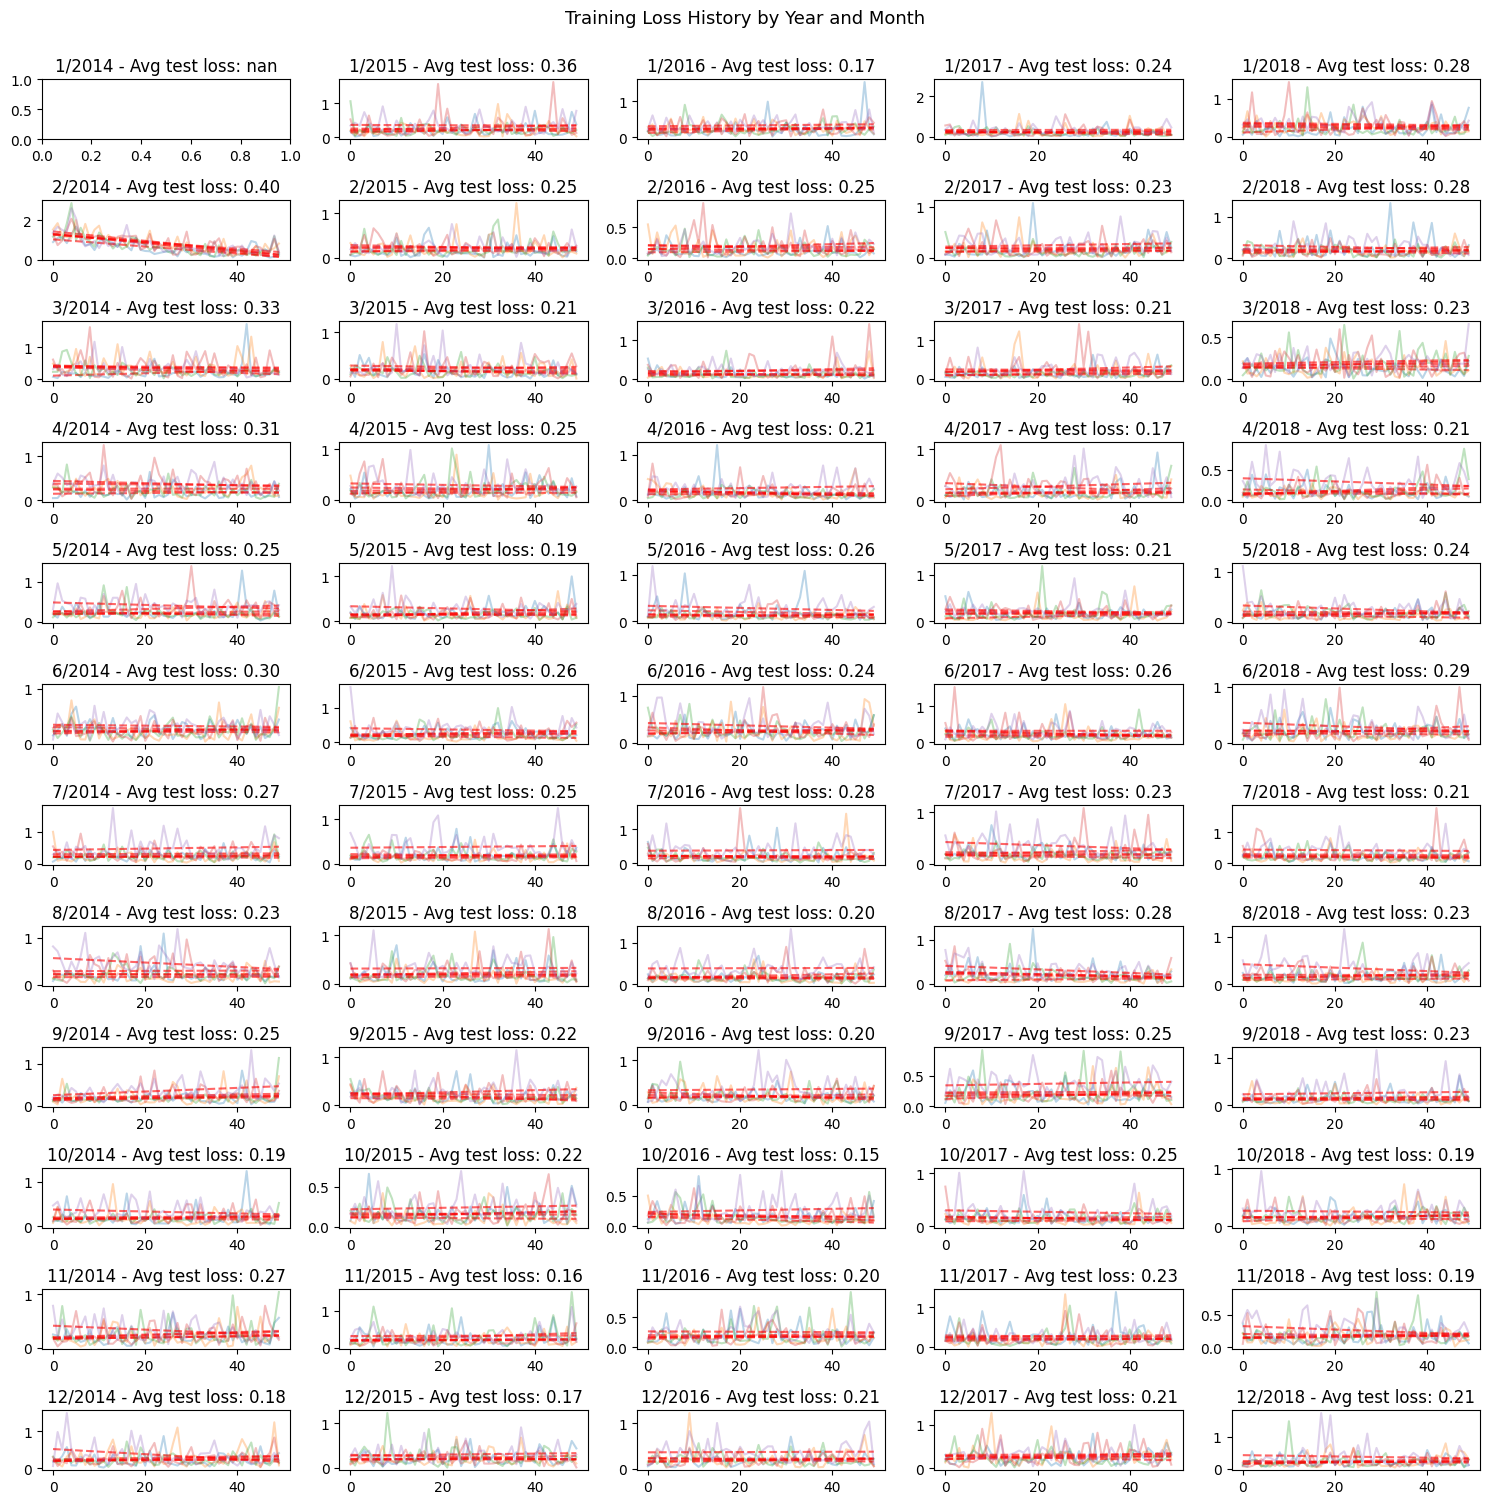

In [12]:
# Training loss history by year and month for 1 client

years = df6_best_1client['test_year'].unique()
years = np.sort(years)
months = df6_best_1client['test_month'].unique()
months = np.sort(months)
clients = df6_best_1client['client_num'].unique()

# Determine the number of rows and columns for the subplots grid
n_rows = len(months)
n_cols = len(years)

# Create a figure and axes array of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15), constrained_layout=True)

for j, year in enumerate(years):
    for i, month in enumerate(months):
        ax = axes[i, j] if n_rows > 1 and n_cols > 1 else (axes[j] if n_cols > 1 else axes[i])
        subset = df6_best_1client[(df6_best_1client['test_year'] == year) & (df6_best_1client['test_month'] == month)]
        avg_test_loss = subset['test_loss'].mean()
        
        ax.set_title(f'{month}/{year} - Avg test loss: {avg_test_loss:.2f}')
        for client_num in clients[:5]:
            client_data = subset[subset['client_num'] == client_num]
            if not client_data.empty:
                training_loss_history = client_data['training_loss_history'].values[0]
                epochs = np.arange(len(training_loss_history))
                ax.plot(training_loss_history, label=f'Client {client_num}', alpha=0.3)
                
                # Add linear regression line
                if len(epochs) > 1:  # Ensure there are enough data points to fit a line
                    coeffs = np.polyfit(epochs, training_loss_history, 1)
                    linear_fit = np.poly1d(coeffs)
                    ax.plot(epochs, linear_fit(epochs), linestyle='--', color='red', alpha=0.6)

# Add a main title to the figure
fig.suptitle('Training Loss History by Year and Month', fontsize=13, y=1)

# Add legend outside the subplots
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1))
plt.tight_layout()
plt.show()

In [36]:
# Compute best results from Scenario 6 with 40 clients

df6_40clients = pickle.load(open('FL_results/Scenario6/40clients_batchsize10percent_50epochs.pkl', 'rb'))

# compute nbr of gs values
nbr_gs_values = len(df6_40clients['lr'].unique()) * len(df6_40clients['weight_decay'].unique()) * len(df6_40clients['memory_weight'].unique())
print(f'Scenario 6 tested with {nbr_gs_values} different hyperparameters combinations and {len(df6_40clients.client_num.unique())} client(s)')

best_params = df6_40clients.groupby(['lr', 'weight_decay', 'memory_weight'])['test_loss'].mean().idxmin()

print(f'Best parameters: lr={best_params[0]}, weight_decay={best_params[1]}, memory_weight={best_params[2]}')

display(df6_40clients[(df6_40clients['lr']==best_params[0]) & (df6_40clients['weight_decay']==best_params[1]) & (df6_40clients['memory_weight']==best_params[2])].groupby('test_year')['test_loss'].mean())

print('Overall loss over 5 years: %.3f ± %.3f' % (df6_40clients[(df6_40clients['lr']==best_params[0]) & (df6_40clients['weight_decay']==best_params[1]) & (df6_40clients['memory_weight']==best_params[2])].groupby('test_year')['test_loss'].mean().values.mean(), df6_40clients[(df6_40clients['lr']==best_params[0]) & (df6_40clients['weight_decay']==best_params[1]) & (df6_40clients['memory_weight']==best_params[2])].groupby('test_year')['test_loss'].mean().values.std()))

Scenario 6 tested with 1 different hyperparameters combinations and 40 client(s)
Best parameters: lr=0.001, weight_decay=0.05, memory_weight=0.75


test_year
2014    0.357072
2015    0.337895
2016    0.303337
2017    0.362118
2018    0.357404
Name: test_loss, dtype: float64

Overall loss over 5 years: 0.344 ± 0.022


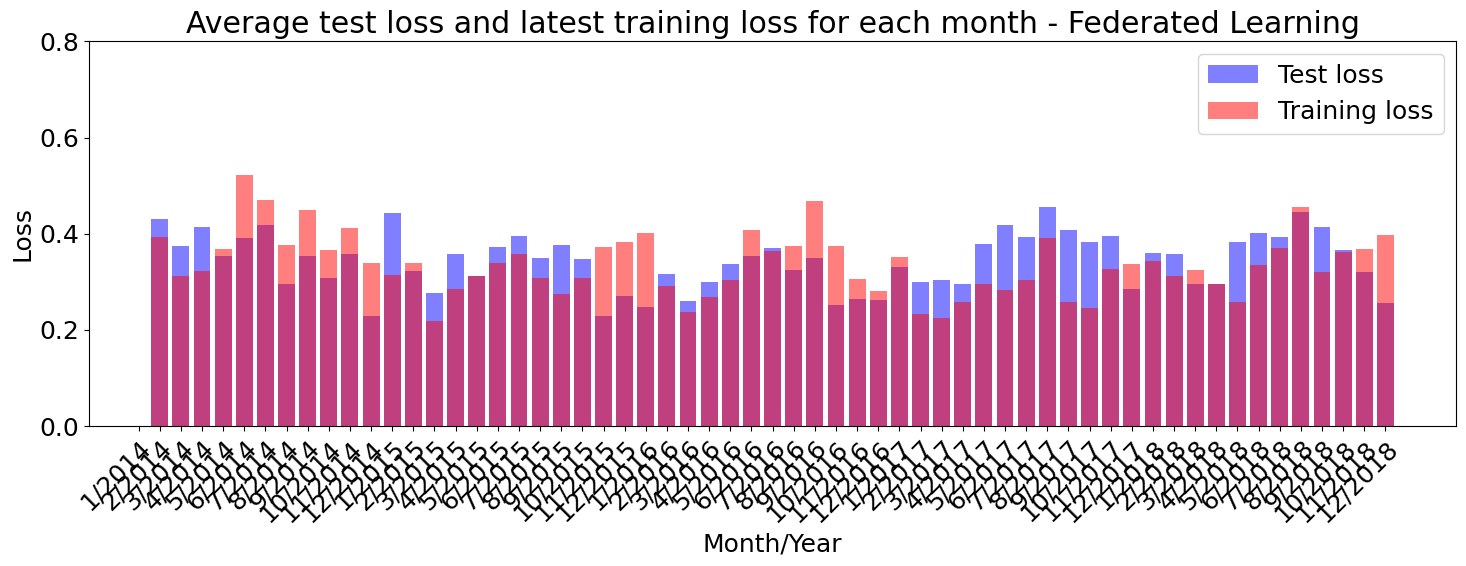

In [38]:
# for each month, year print the avg training loss of the latest epoch and the avg test loss - 40 clients

best_params = df6_40clients.groupby(['lr', 'weight_decay', 'memory_weight'])['test_loss'].mean().idxmin()

lr = best_params[0]
weight_decay = best_params[1]
memory_weight = best_params[2]

df6_best_40clients = df6_40clients[(df6_40clients['lr']==lr) & (df6_40clients['weight_decay']==weight_decay) & (df6_40clients['memory_weight']==memory_weight)]

# Plot as barplot the avg test loss and latest training loss for each month
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

for year in np.sort(df6_best_40clients['test_year'].unique()):
    for month in np.sort(df6_best_40clients['test_month'].unique()):
        subset = df6_best_40clients[(df6_best_40clients['test_year'] == year) & (df6_best_40clients['test_month'] == month)]
        avg_test_loss = subset['test_loss'].mean()
        avg_train_loss = np.mean([np.mean(subset['training_loss_history'].values[i][-1]) for i in range(len(subset))])
        ax.bar(f'{month}/{year}', avg_test_loss, color='blue', alpha=0.5)
        ax.bar(f'{month}/{year}', avg_train_loss, color='red', alpha=0.5)
        
ax.set_title('Average test loss and latest training loss for each month - Federated Learning')
ax.set_ylabel('Loss')
ax.set_xlabel('Month/Year')
ax.legend(['Test loss', 'Training loss'])
plt.xticks(rotation=45, ha='right',rotation_mode='anchor')
plt.ylim(0, 0.8)
plt.tight_layout()
plt.show()

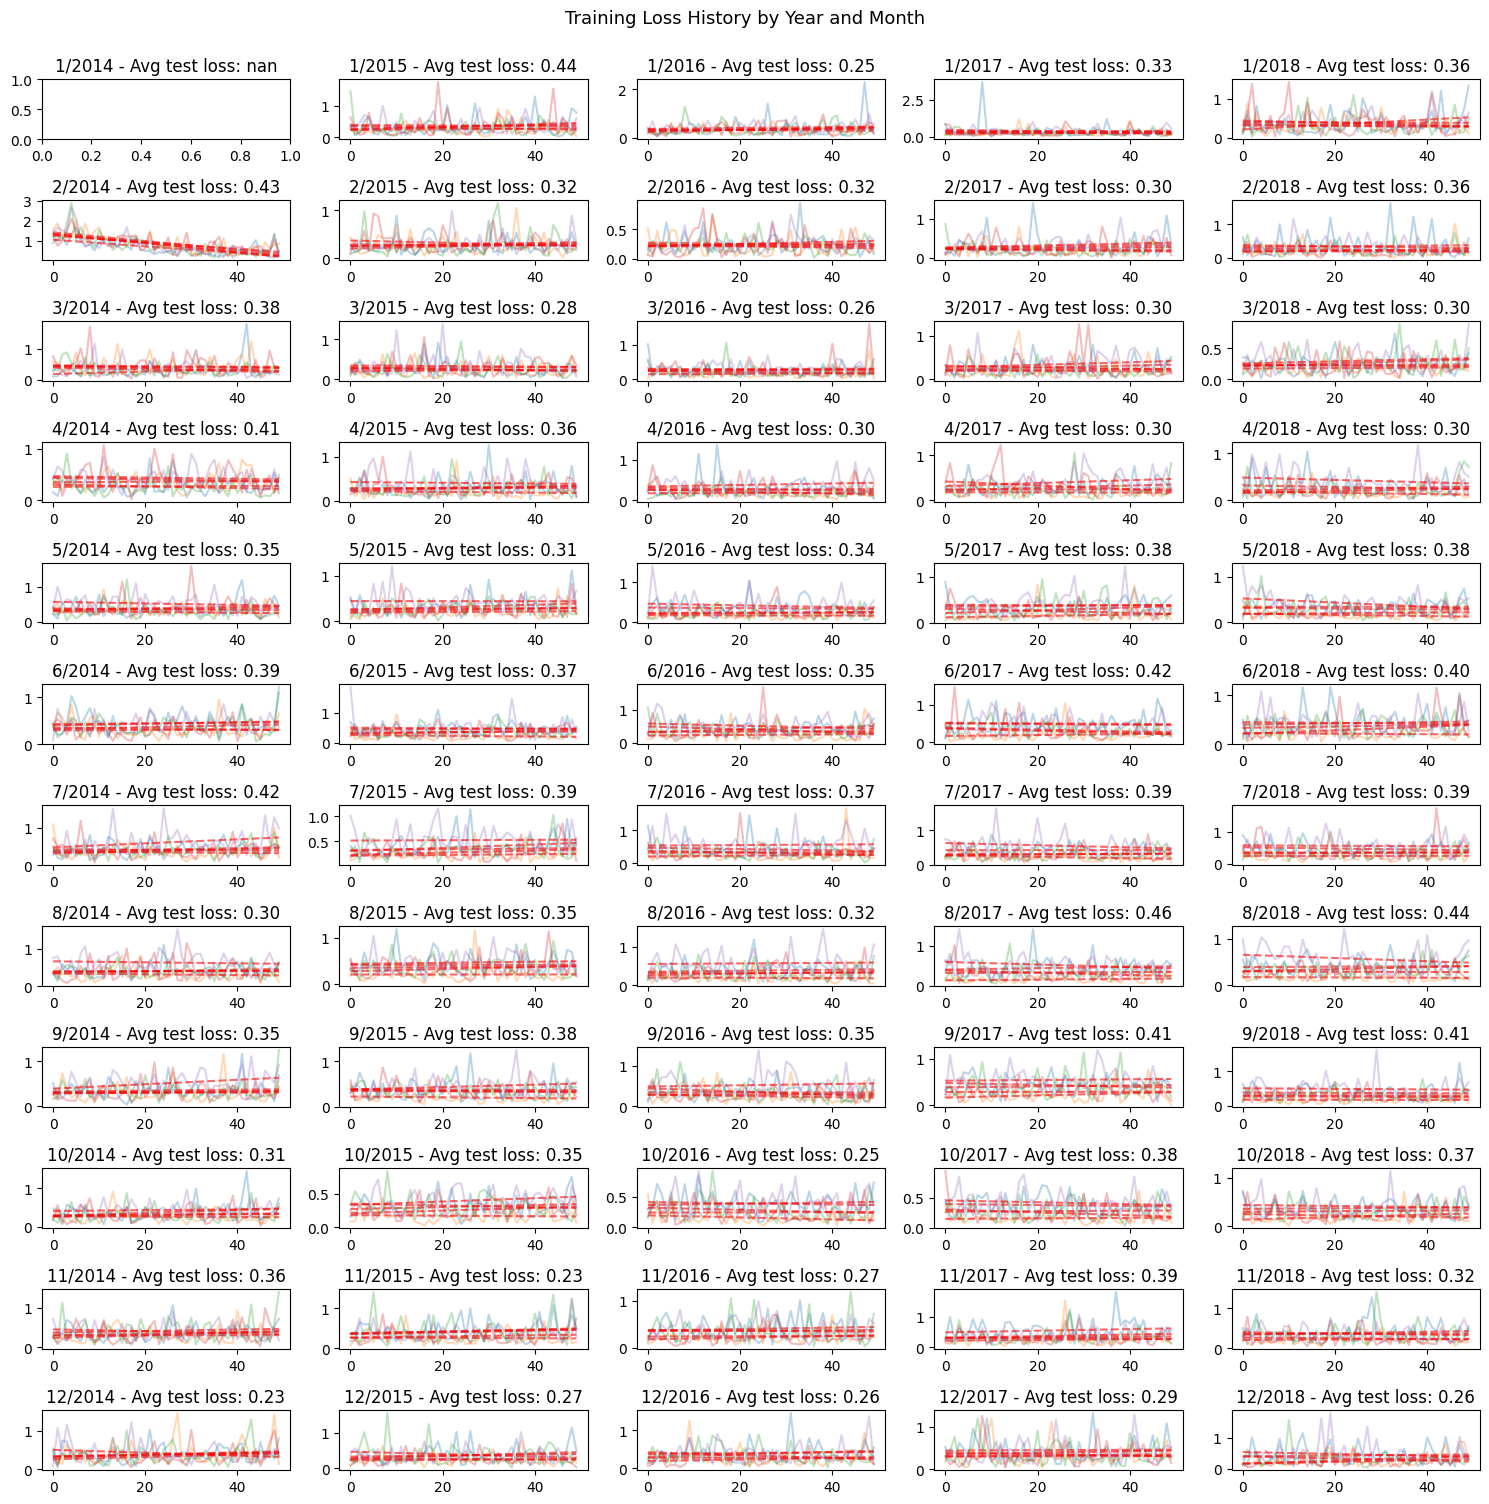

In [13]:
# Training loss history by year and month for 40 clients

years = df6_best_40clients['test_year'].unique()
years = np.sort(years)
months = df6_best_40clients['test_month'].unique()
months = np.sort(months)
clients = df6_best_40clients['client_num'].unique()

# Determine the number of rows and columns for the subplots grid
n_rows = len(months)
n_cols = len(years)

# Create a figure and axes array of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15), constrained_layout=True)

for j, year in enumerate(years):
    for i, month in enumerate(months):
        ax = axes[i, j] if n_rows > 1 and n_cols > 1 else (axes[j] if n_cols > 1 else axes[i])
        subset = df6_best_40clients[(df6_best_40clients['test_year'] == year) & (df6_best_40clients['test_month'] == month)]
        avg_test_loss = subset['test_loss'].mean()
        
        ax.set_title(f'{month}/{year} - Avg test loss: {avg_test_loss:.2f}')
        for client_num in clients[:5]:
            client_data = subset[subset['client_num'] == client_num]
            if not client_data.empty:
                training_loss_history = client_data['training_loss_history'].values[0]
                epochs = np.arange(len(training_loss_history))
                ax.plot(training_loss_history, label=f'Client {client_num}', alpha=0.3)
                
                # Add linear regression line
                if len(epochs) > 1:  # Ensure there are enough data points to fit a line
                    coeffs = np.polyfit(epochs, training_loss_history, 1)
                    linear_fit = np.poly1d(coeffs)
                    ax.plot(epochs, linear_fit(epochs), linestyle='--', color='red', alpha=0.6)

# Add a main title to the figure
fig.suptitle('Training Loss History by Year and Month', fontsize=13, y=1)

# Add legend outside the subplots
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1))
plt.tight_layout()
plt.show()